In [1]:
import os
import cv2
import torch
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import models, transforms

In [2]:
def get_image(path: str, size: int=384) -> None:
    return cv2.resize(src=cv2.cvtColor(src=cv2.imread(path, cv2.IMREAD_COLOR), code=cv2.COLOR_BGR2RGB), dsize=(size, size), interpolation=cv2.INTER_AREA)


def show_images(image_1: np.ndarray, image_2: np.ndarray) -> None:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_1, cmap="gnuplot2")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image_2, cmap="gnuplot2")
    plt.axis("off")
    plt.show()

    
TEST_IMAGES_BASE_PATH = "../input/paddy-disease-classification/test_images"
MODEL_PATH = "../input/pdcd169aena384-ds/saves/state.pt"
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.49699, 0.58823, 0.23049],
                                                     [0.22591, 0.22614, 0.18264]),
                                ])
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Model(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Model, self).__init__()

        self.encoder = models.densenet169(pretrained=False, progress=True)
        # self.freeze()
        self.encoder = nn.Sequential(*[*self.encoder.children()][:-1])

        self.decoder = nn.Sequential()
        self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=1664, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN1", nn.ReLU())
        self.decoder.add_module("UP1", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN2", nn.ReLU())
        self.decoder.add_module("UP2", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN3", nn.ReLU())
        self.decoder.add_module("UP3", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN4", nn.ReLU())
        self.decoder.add_module("UP4", nn.Upsample(scale_factor=2))
        self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
        self.decoder.add_module("AN5", nn.ReLU())
        self.decoder.add_module("UP5", nn.Upsample(scale_factor=2))
    
    def freeze(self):
        for params in self.parameters(): params.requires_grad = False
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

model = Model()

In [4]:
def decode_image(model=None, image=None, device=None, path: str=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    with torch.no_grad(): _, decoded = model(transforms.ToTensor()(image).unsqueeze(dim=0).to(device))
        
    return np.clip(decoded.squeeze().detach().cpu().numpy().transpose(1, 2, 0)*255, 0, 255).astype("uint8")

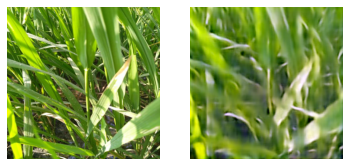

In [5]:
names = os.listdir(TEST_IMAGES_BASE_PATH) 
index = r.randint(0, len(os.listdir(TEST_IMAGES_BASE_PATH))-1)

image = get_image(os.path.join(TEST_IMAGES_BASE_PATH, names[index]))
decoded_image = decode_image(model, image, DEVICE, MODEL_PATH)

show_images(image, decoded_image)